# Import and Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS
from discofuzz import FourierFuzzifier

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
sim_metrics = [s.value for s in sim_metrics_enum]
fuzzifier = FourierFuzzifier(
    sigma=0.1,
    kernel_size=8
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Visualization Helpers

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Callable


class Visualizer:
    """Visualizes complex heatmaps built from Fourier series coefficients."""

    def __init__(self, fuzzy_sample: np.ndarray, N: int = 200, figsize = (6, 5)) -> None:
        """
        Initialize the visualizer by computing H(x,y) = fx(x) * fy(y)
        on a [0,1) grid of size N.

        Args:
            fuzzy_sample: Fourier coefficients with shape (2, K).
            N: Grid resolution.
        """
        if fuzzy_sample.shape[0] != 2:
            raise ValueError(f"Expected fuzzy_sample shape (2, K); got {fuzzy_sample.shape}")

        self.figsize = figsize
        self.N = N
        self.H = self._compute_heatmap(fuzzy_sample)

    def _compute_heatmap(self, fuzzy_sample: np.ndarray) -> np.ndarray:
        """Compute the complex heatmap from Fourier coefficients."""
        x = np.linspace(0.0, 1.0, self.N, endpoint=False)
        k = np.arange(fuzzy_sample.shape[1])
        basis = np.exp(1j * 2.0 * np.pi * np.outer(k, x))  # (K, N)

        fx = tf.math.reduce_sum(fuzzy_sample[0][:, None] * basis, axis=0)
        fy = tf.math.reduce_sum(fuzzy_sample[1][:, None] * basis, axis=0)

        return (fx[:, None] * fy[None, :]).numpy()

    def _plot(
        self,
        data: np.ndarray,
        title: str,
        colorbar_label: str,
        cmap: str = "viridis",
    ) -> None:
        """Shared plotting logic for all visualization methods."""
        plt.figure(figsize=self.figsize)
        plt.imshow(data, origin="lower", aspect="equal", extent=[0.0, 1.0, 0.0, 1.0], cmap=cmap)
        plt.title(title)
        plt.xlabel("y ∈ [0, 1]")
        plt.ylabel("x ∈ [0, 1]")
        plt.colorbar(label=colorbar_label)
        plt.tight_layout()
        plt.show()

    def plot_real(self, title: str = "Real part") -> None:
        """Plot the real part of the heatmap."""
        self._plot(self.H.real, title, "Re")

    def plot_imag(self, title: str = "Imaginary part") -> None:
        """Plot the imaginary part of the heatmap."""
        self._plot(self.H.imag, title, "Im")

    def plot_magnitude(self, title: str = "Magnitude") -> None:
        """Plot the magnitude of the heatmap."""
        self._plot(np.abs(self.H), title, "|H|")

    def plot_phase(self, title: str = "Phase") -> None:
        """Plot the phase of the heatmap."""
        self._plot(np.angle(self.H), title, "arg(H)")

    def plot_all(self) -> None:
        """Plot all four views: real, imaginary, magnitude, and phase."""
        fig, axes = plt.subplots(2, 2, figsize=(10, 9))
        views = [
            (self.H.real, "Real part", "Re"),
            (self.H.imag, "Imaginary part", "Im"),
            (np.abs(self.H), "Magnitude", "|H|"),
            (np.angle(self.H), "Phase", "arg(H)"),
        ]

        for ax, (data, title, label) in zip(axes.flat, views):
            im = ax.imshow(data, origin="lower", aspect="equal", extent=[0.0, 1.0, 0.0, 1.0])
            ax.set_title(title)
            ax.set_xlabel("y ∈ [0, 1]")
            ax.set_ylabel("x ∈ [0, 1]")
            fig.colorbar(im, ax=ax, label=label)

        plt.tight_layout()
        plt.show()

# Fuzzification

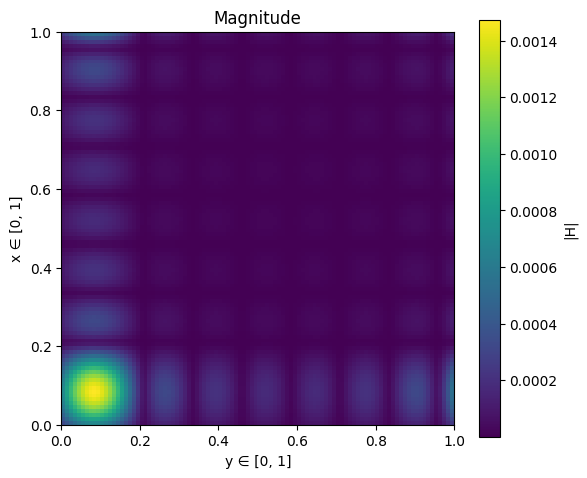

In [19]:
sample_pt = [0.5, 0.5]
fuzzy_sample = fuzzifier._get_gaussian_at_mu_batch(tf.constant(sample_pt))
visualizer = Visualizer(fuzzy_sample, 100)
visualizer.plot_magnitude()